In [1]:
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
loans = joblib.load("../data/final_model_data.joblib")

# import pandas as pd
#
# # Convert the issue_d column to a datetime object
# loans['issue_d'] = pd.to_datetime(loans['issue_d'])
#
# # Create a boolean mask for rows with issue_d in 2018
# mask = loans['issue_d'].dt.year == 2018
#
# # Filter the data using the mask
# loans = loans[mask]

loans = loans.head(10000)

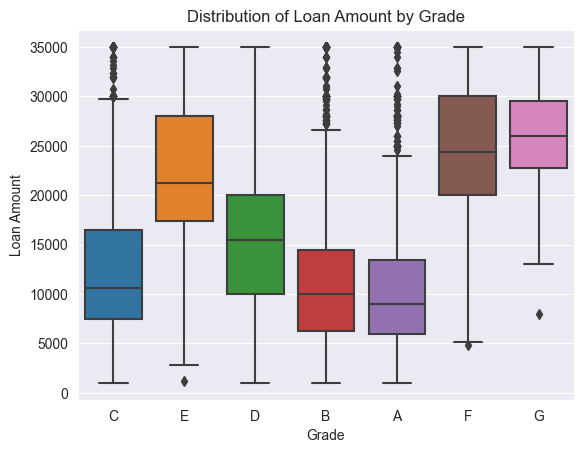

In [3]:
import pandas as pd
import seaborn as sns

# Create box plot of loan amount by grade
sns.boxplot(x="grade", y="loan_amnt", data=loans)
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
plt.xlabel("Grade")
plt.ylabel("Loan Amount")
plt.title("Distribution of Loan Amount by Grade")
plt.show()

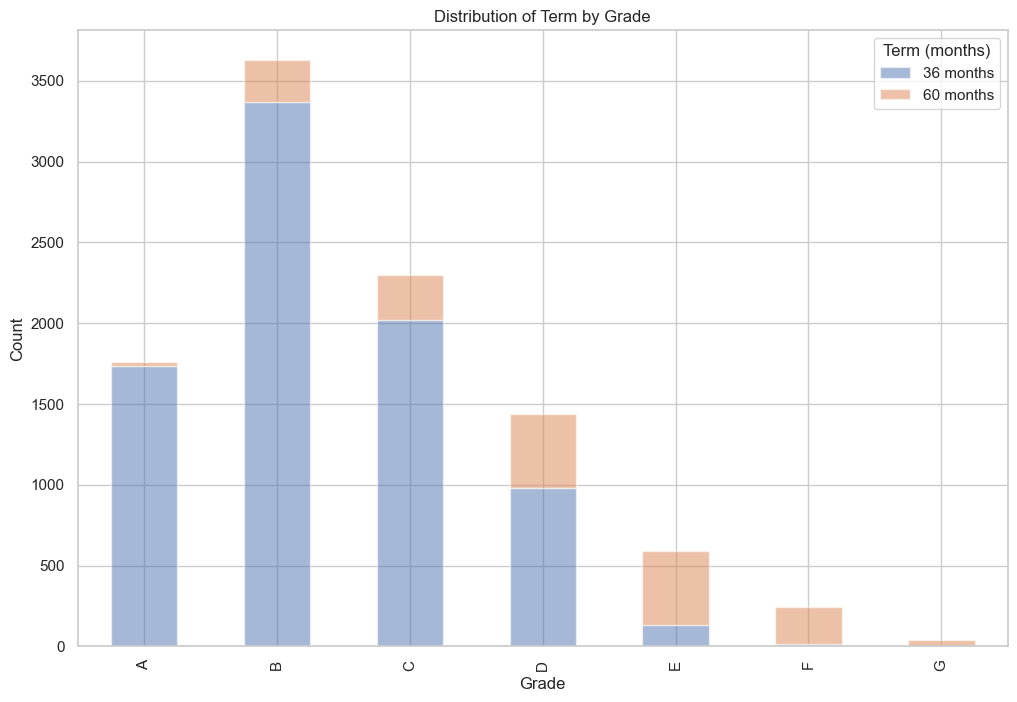

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Group loans by grade and term, and calculate the count for each group
grouped = loans.groupby(["grade", "term"]).size().unstack()

# Create stacked bar chart of term counts by grade
grouped.plot(kind="bar", stacked=True, alpha=0.5)

plt.xlabel("Grade")
plt.ylabel("Count")
plt.title("Distribution of Term by Grade")
plt.legend(title="Term (months)", loc="upper right")
plt.show()

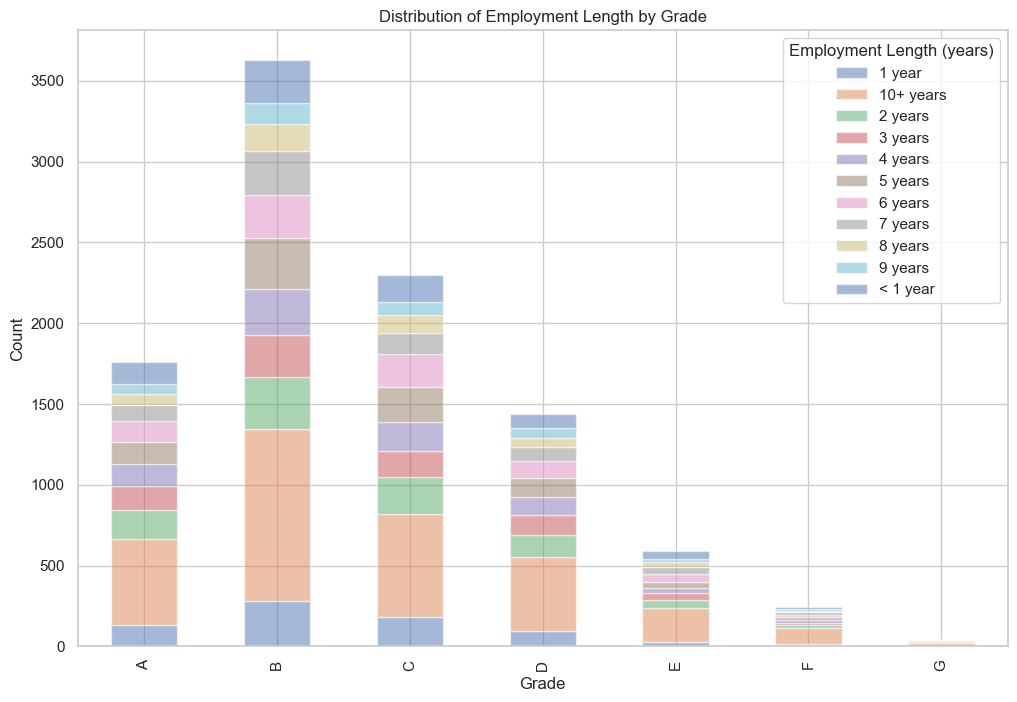

In [5]:
import matplotlib.pyplot as plt

# Group loans by grade and emp_length, and calculate the count for each group
grouped = loans.groupby(["grade", "emp_length"]).size().unstack()

# Create stacked bar chart of emp_length counts by grade
grouped.plot(kind="bar", stacked=True, alpha=0.5)

plt.xlabel("Grade")
plt.ylabel("Count")
plt.title("Distribution of Employment Length by Grade")
plt.legend(title="Employment Length (years)", loc="upper right")
plt.show()

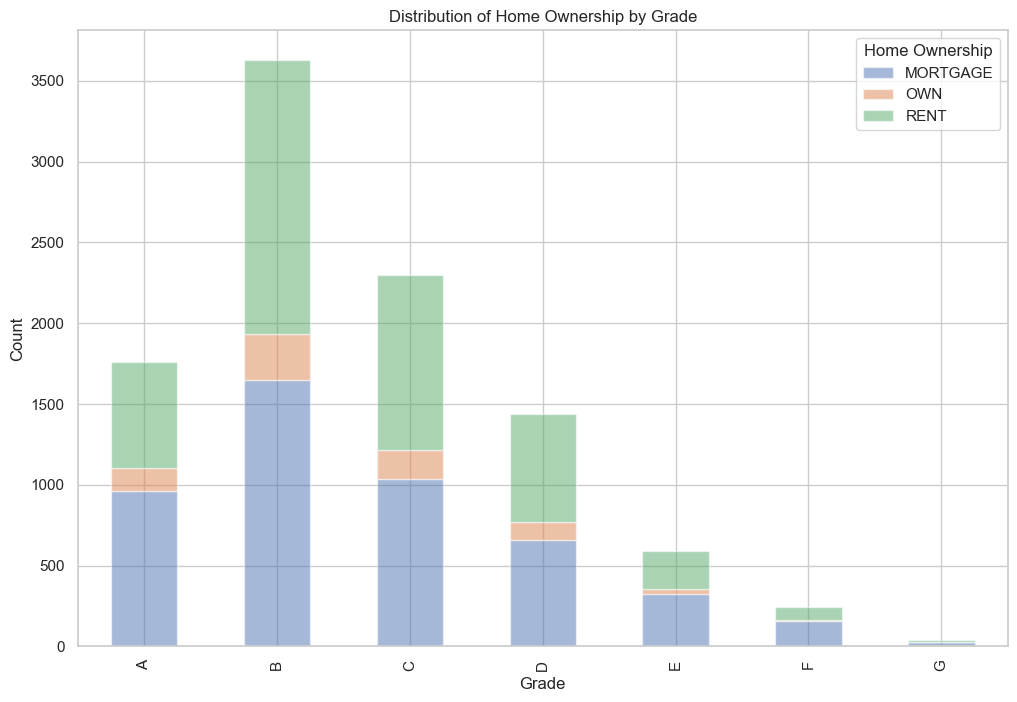

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Group loans by grade and home_ownership, and calculate the count for each group
grouped = loans.groupby(["grade", "home_ownership"]).size().unstack()

# Create stacked bar chart of home_ownership counts by grade
grouped.plot(kind="bar", stacked=True, alpha=0.5)

plt.xlabel("Grade")
plt.ylabel("Count")
plt.title("Distribution of Home Ownership by Grade")
plt.legend(title="Home Ownership", loc="upper right")
plt.show()


In [7]:
loans.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1909203 to 1902624
Data columns (total 71 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   loan_amnt                           10000 non-null  float64       
 1   term                                10000 non-null  object        
 2   emp_length                          10000 non-null  object        
 3   home_ownership                      10000 non-null  object        
 4   annual_inc                          10000 non-null  float64       
 5   purpose                             10000 non-null  object        
 6   dti                                 10000 non-null  float64       
 7   delinq_2yrs                         10000 non-null  float64       
 8   cr_hist_age_mths                    10000 non-null  float64       
 9   fico_range_low                      10000 non-null  float64       
 10  fico_range_high    

In [8]:
train, test = train_test_split(loans, test_size=0.2, shuffle=False)
train, test = train.copy(), test.copy()
print(f"The test set contains {len(test):,} loans.")

The test set contains 2,000 loans.


In [9]:
onehot_cols = ["term", "application_type", "home_ownership", "purpose"]
ordinal_cols = {
    "emp_length": [
        "< 1 year",
        "1 year",
        "2 years",
        "3 years",
        "4 years",
        "5 years",
        "6 years",
        "7 years",
        "8 years",
        "9 years",
        "10+ years",
    ],
}

In [10]:
def run_pipeline_cv_nn(
    data,
    onehot_cols,
    ordinal_cols,
    batch_size,
):
    X = data.drop(columns=["issue_d", "date", "grade", "grade_encoded", "sub_grade", "recovered_percentage", "expected_return"])
    y = data["grade_encoded"]

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary", handle_unknown="error")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    history_list = []
    model_list = []
    transformer_list = []

    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        print(X_train.keys())
        X_train = transformer.fit_transform(X_train)
        X_valid = transformer.transform(X_valid)

        input_nodes = X_train.shape[1]

        # Define the model architecture
        model = Sequential()
        model.add(Input(shape=input_nodes))
        model.add(Dense(64, activation="relu"))
        model.add(Dropout(0.3, seed=0))
        model.add(Dense(32, activation="relu"))
        model.add(Dropout(0.3, seed=1))
        model.add(Dense(16, activation="relu"))
        model.add(Dropout(0.3, seed=1))
        model.add(Dense(7, activation="softmax"))
        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

        # # Define the EarlyStopping callback
        # early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        history = model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=300,
            validation_data=(X_valid, y_valid),
            verbose=2,
            # callbacks=[early_stopping],  # Add the EarlyStopping callback
        )

        history_list.append(history.history)
        model_list.append(model)
        transformer_list.append(transformer)

    return history_list, model_list, transformer_list


In [11]:
# Encode loan grades as integers
grade_encoder = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
}
train["grade_encoded"] = train["grade"].apply(lambda x: grade_encoder[x])
test["grade_encoded"] = test["grade"].apply(lambda x: grade_encoder[x])

# Run the pipeline with cross-validation
nn_history_list, nn_model_list, nn_transformer_list = run_pipeline_cv_nn(
    train,
    onehot_cols,
    ordinal_cols,
    batch_size=128,
)

Index(['loan_amnt', 'term', 'emp_length', 'home_ownership', 'annual_inc',
       'purpose', 'dti', 'delinq_2yrs', 'cr_hist_age_mths', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'inv_mths_since_last_delinq',
       'inv_mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'inv_mths_since_last_major_derog', 'application_type',
       'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'inv_mo_sin_rcnt_rev_tl_op', 'inv_mo_sin_rcnt_tl', 'mort_acc',
       'inv_mths_since_recent_bc', 'inv_mths_since_recent_bc_dlq',
       'inv_mths_since_recent_inq', 'inv_mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       '

In [12]:
def run_pipeline_cv_svm(
    data,
    onehot_cols,
    ordinal_cols,
):
    X = data.drop(columns=["issue_d", "date", "grade", "grade_encoded", "sub_grade", "recovered_percentage", "expected_return"])
    y = data["grade_encoded"]

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary", handle_unknown="error")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    history_list = []
    model_list = []
    transformer_list = []

    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        print("before trans: ")
        print(X_train.shape)
        print(X_valid.shape)
        X_train = transformer.fit_transform(X_train)
        X_valid = transformer.transform(X_valid)

        print("after trans: ")
        print(X_train.shape)
        print(X_valid.shape)

        # Define the parameter grid to search
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': [0.01, 0.1, 1]
        }

        # Define the SVM model
        svm = SVC(kernel='linear')

        # Use GridSearchCV to search for the best hyperparameters
        grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Print the best hyperparameters and their corresponding score
        print("Best hyperparameters:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)

        history_list.append(None)
        model_list.append(grid_search.best_estimator_)
        transformer_list.append(transformer)

    return history_list, model_list, transformer_list

In [13]:
# Run the pipeline with cross-validation
svm_history_list, svm_model_list, svm_transformer_list = run_pipeline_cv_svm(
    train,
    onehot_cols,
    ordinal_cols,
)

before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.7753125
before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.77515625
before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.780625
before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.775625
before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.77359375


In [14]:
def run_pipeline_cv_rf(data, onehot_cols, ordinal_cols):
    X = data.drop(columns=["issue_d", "date", "grade", "grade_encoded", "sub_grade", "recovered_percentage", "expected_return"])
    y = data["grade_encoded"]

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary", handle_unknown="error")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    history_list = []
    model_list = []
    transformer_list = []

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
    }

    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        X_train = transformer.fit_transform(X_train)
        X_valid = transformer.transform(X_valid)

        # Define the model architecture
        model = RandomForestClassifier(random_state=0)

        # Use GridSearchCV to search over a grid of hyperparameters
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Evaluate the model
        y_pred = grid_search.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_pred)
        print(f"Accuracy on validation set: {accuracy:.4f}")

        history_list.append({"accuracy": accuracy})
        model_list.append(grid_search)
        transformer_list.append(transformer)

    return history_list, model_list, transformer_list

In [15]:
# Run the pipeline with cross-validation
rf_history_list, rf_model_list, rf_transformer_list = run_pipeline_cv_rf(
    train,
    onehot_cols,
    ordinal_cols,
)

Accuracy on validation set: 0.6644
Accuracy on validation set: 0.6750
Accuracy on validation set: 0.6656
Accuracy on validation set: 0.6481
Accuracy on validation set: 0.6569


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

def run_pipeline_cv_dt(data, onehot_cols, ordinal_cols):
    X = data.drop(columns=["issue_d", "date", "grade", "grade_encoded", "sub_grade", "recovered_percentage", "expected_return"])
    y = data["grade_encoded"]

    transformer = ColumnTransformer(
        [
            ('onehot', OneHotEncoder(drop="if_binary", handle_unknown="error"), onehot_cols),
            ('ordinal', OrdinalEncoder(categories=list(ordinal_cols.values())), list(ordinal_cols.keys())),
            ('imputer', SimpleImputer(strategy='median'), selector(dtype_include='number'))
        ],
        remainder=StandardScaler()
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    history_list = []
    model_list = []
    transformer_list = []

    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        pipeline = Pipeline([
            ('preprocess', transformer),
            ('model', DecisionTreeClassifier())
        ])

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_valid)

        accuracy = accuracy_score(y_valid, y_pred)
        precision = precision_score(y_valid, y_pred, average='weighted')
        recall = recall_score(y_valid, y_pred, average='weighted')
        f1 = f1_score(y_valid, y_pred, average='weighted')

        history_list.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
        model_list.append(pipeline)
        transformer_list.append(transformer)

    return history_list, model_list, transformer_list


In [17]:
# Run the pipeline with cross-validation for Decision Trees
dt_history_list, dt_model_list, dt_transformer_list = run_pipeline_cv_dt(
    train,
    onehot_cols,
    ordinal_cols,
)

In [18]:
from sklearn.metrics import accuracy_score

# Load the test set and extract the true labels
X_test = test.drop(columns=["issue_d", "date", "grade", "grade_encoded", "sub_grade", "recovered_percentage", "expected_return"])
y_test = test["grade_encoded"]

# Make predictions using the ensemble model
predictions_list_nn = []
predictions_list = []

for i in range(len(nn_model_list)):
    transformer = nn_transformer_list[i]
    model = nn_model_list[i]

    X_test_transformed = transformer.transform(X_test)
    y_pred = model.predict(X_test_transformed)
    predictions_list_nn.append(y_pred)

for i in range(len(svm_model_list)):
    transformer = svm_transformer_list[i]
    model = svm_model_list[i]

    X_test_transformed = transformer.transform(X_test)
    y_pred = model.predict(X_test_transformed)
    predictions_list.append(y_pred)

# for i in range(len(rf_model_list)):
#     transformer = rf_transformer_list[i]
#     model = rf_model_list[i]
#
#     X_test_transformed = transformer.transform(X_test)
#     y_pred = model.predict(X_test_transformed)
#     predictions_list.append(y_pred)

for model in dt_model_list:
    y_pred = model.predict(X_test)
    predictions_list.append(y_pred)

# Convert the predictions to class labels
class_predictions_list = [np.argmax(predictions, axis=1) for predictions in predictions_list_nn]

for predictions in predictions_list:
    class_predictions_list.append(predictions)

# Combine the predictions from each model
class_predictions_array = np.array(class_predictions_list)

# Perform a majority vote along each row
final_predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=class_predictions_array)
print(final_predictions.shape)
print(y_test.shape)

# Calculate the accuracy
accuracy = accuracy_score(y_test, final_predictions)

print("Ensemble accuracy:", accuracy)


63/63 [==============================] - 0s 286us/step
(2000,)
(2000,)
Ensemble accuracy: 0.861


In [19]:
# Compute precision, recall, and F1-score of the ensemble model
precision = precision_score(y_test, final_predictions, average="weighted", zero_division=0)
recall = recall_score(y_test, final_predictions, average="weighted", zero_division=0)
f1 = f1_score(y_test, final_predictions, average="weighted", zero_division=0)

print(f"Precision of ensemble model on test set: {precision:.4f}")
print(f"Recall of ensemble model on test set: {recall:.4f}")
print(f"F1-score of ensemble model on test set: {f1:.4f}")

Precision of ensemble model on test set: 0.8593
Recall of ensemble model on test set: 0.8610
F1-score of ensemble model on test set: 0.8594


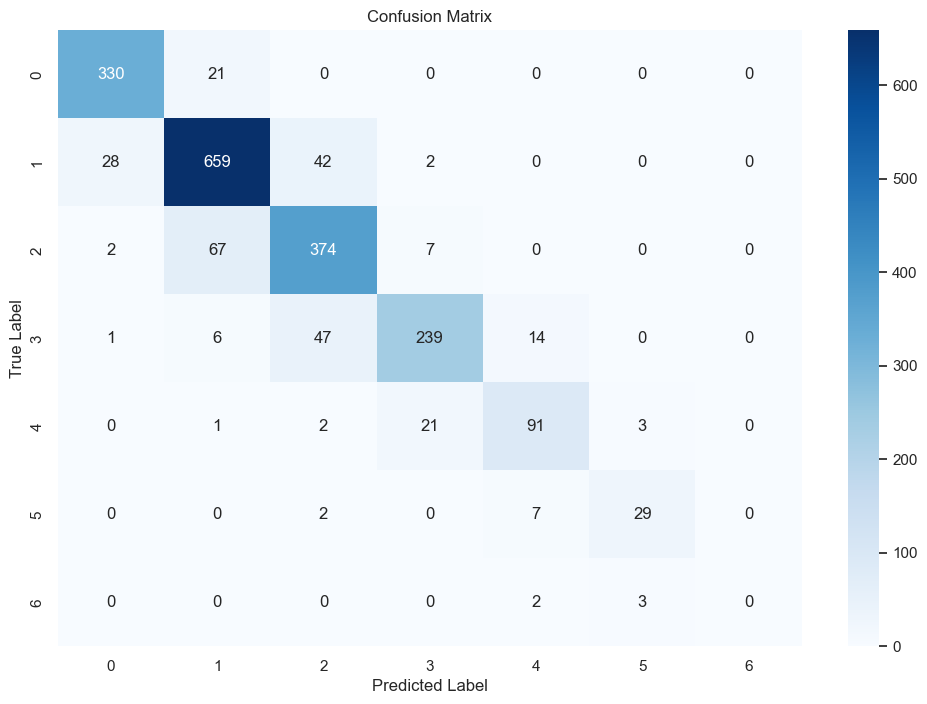

In [20]:
# Compute the confusion matrix of the ensemble model
confusion = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix as a heatmap
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Random Forest model
rf_accuracies = []
rf_precisions = []
rf_recalls = []
rf_f1_scores = []

for model in rf_model_list:
    rf_predictions = model.predict(X_test_transformed)
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    rf_precision = precision_score(y_test, rf_predictions, average="weighted")
    rf_recall = recall_score(y_test, rf_predictions, average="weighted")
    rf_f1 = f1_score(y_test, rf_predictions, average="weighted")

    rf_accuracies.append(rf_accuracy)
    rf_precisions.append(rf_precision)
    rf_recalls.append(rf_recall)
    rf_f1_scores.append(rf_f1)

print("Random Forest Models:")
print("Average Performance:")
print(f"Accuracy: {sum(rf_accuracies) / len(rf_accuracies):.4f}")
print(f"Precision: {sum(rf_precisions) / len(rf_precisions):.4f}")
print(f"Recall: {sum(rf_recalls) / len(rf_recalls):.4f}")
print(f"F1-Score: {sum(rf_f1_scores) / len(rf_f1_scores):.4f}")


# SVM model
svm_accuracies = []
svm_precisions = []
svm_recalls = []
svm_f1_scores = []

for model in svm_model_list:
    svm_predictions = model.predict(X_test_transformed)
    svm_accuracy = accuracy_score(y_test, svm_predictions)
    svm_precision = precision_score(y_test, svm_predictions, average="weighted")
    svm_recall = recall_score(y_test, svm_predictions, average="weighted")
    svm_f1 = f1_score(y_test, svm_predictions, average="weighted")

    svm_accuracies.append(svm_accuracy)
    svm_precisions.append(svm_precision)
    svm_recalls.append(svm_recall)
    svm_f1_scores.append(svm_f1)

print("SVM Models:")
print("Average Performance:")
print(f"Accuracy: {sum(svm_accuracies) / len(svm_accuracies):.4f}")
print(f"Precision: {sum(svm_precisions) / len(svm_precisions):.4f}")
print(f"Recall: {sum(svm_recalls) / len(svm_recalls):.4f}")
print(f"F1-Score: {sum(svm_f1_scores) / len(svm_f1_scores):.4f}")

# Neural Network (NN) model
nn_accuracies = []
nn_precisions = []
nn_recalls = []
nn_f1_scores = []

for model, transformer in zip(nn_model_list, nn_transformer_list):
    X_test_transformed = transformer.transform(X_test)
    nn_predictions = model.predict(X_test_transformed)
    nn_predictions = np.argmax(nn_predictions, axis=1)
    nn_accuracy = accuracy_score(y_test, nn_predictions)
    nn_precision = precision_score(y_test, nn_predictions, average="weighted")
    nn_recall = recall_score(y_test, nn_predictions, average="weighted")
    nn_f1 = f1_score(y_test, nn_predictions, average="weighted")

    nn_accuracies.append(nn_accuracy)
    nn_precisions.append(nn_precision)
    nn_recalls.append(nn_recall)
    nn_f1_scores.append(nn_f1)

print("Neural Network (NN) Models:")
print(f"Average Performance:")
print(f"Accuracy: {sum(nn_accuracies) / len(nn_accuracies):.4f}")
print(f"Precision: {sum(nn_precisions) / len(nn_precisions):.4f}")
print(f"Recall: {sum(nn_recalls) / len(nn_recalls):.4f}")
print(f"F1-Score: {sum(nn_f1_scores) / len(nn_f1_scores):.4f}")

# Decision Tree (DT) model
dt_accuracies = []
dt_precisions = []
dt_recalls = []
dt_f1_scores = []

for model in dt_model_list:
    dt_predictions = model.predict(X_test)
    dt_accuracy = accuracy_score(y_test, dt_predictions)
    dt_precision = precision_score(y_test, dt_predictions, average="weighted")
    dt_recall = recall_score(y_test, dt_predictions, average="weighted")
    dt_f1 = f1_score(y_test, dt_predictions, average="weighted")

    dt_accuracies.append(dt_accuracy)
    dt_precisions.append(dt_precision)
    dt_recalls.append(dt_recall)
    dt_f1_scores.append(dt_f1)

print("Decision Tree (DT) Models:")
print("Average Performance:")
print(f"Accuracy: {sum(dt_accuracies) / len(dt_accuracies):.4f}")
print(f"Precision: {sum(dt_precisions) / len(dt_precisions):.4f}")
print(f"Recall: {sum(dt_recalls) / len(dt_recalls):.4f}")
print(f"F1-Score: {sum(dt_f1_scores) / len(dt_f1_scores):.4f}")

# Ensemble model
ensemble_accuracy = accuracy_score(y_test, final_predictions)
ensemble_precision = precision_score(y_test, final_predictions, average="weighted")
ensemble_recall = recall_score(y_test, final_predictions, average="weighted")
ensemble_f1 = f1_score(y_test, final_predictions, average="weighted")

print("Ensemble Model:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"F1-Score: {ensemble_f1:.4f}")


/Users/jingren/Documents/QMUL/Project/project-backend/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jingren/Documents/QMUL/Project/project-backend/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jingren/Documents/QMUL/Project/project-backend/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Random Forest Models:
Average Performance:
Accuracy: 0.6727
Precision: 0.6730
Recall: 0.6727
F1-Score: 0.6538
SVM Models:
Average Performance:
Accuracy: 0.7838
Precision: 0.7841
Recall: 0.7838
F1-Score: 0.7829
63/63 [==============================] - 0s 276us/step


/Users/jingren/Documents/QMUL/Project/project-backend/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jingren/Documents/QMUL/Project/project-backend/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jingren/Documents/QMUL/Project/project-backend/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Neural Network (NN) Models:
Average Performance:
Accuracy: 0.8207
Precision: 0.8189
Recall: 0.8207
F1-Score: 0.8193
Decision Tree (DT) Models:
Average Performance:
Accuracy: 0.8459
Precision: 0.8455
Recall: 0.8459
F1-Score: 0.8451
Ensemble Model:
Accuracy: 0.8610
Precision: 0.8593
Recall: 0.8610
F1-Score: 0.8594


/Users/jingren/Documents/QMUL/Project/project-backend/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Save the neural network models and data transformers
for i, model in enumerate(nn_model_list):
    model.save(f"./classification/nn_loan_grade_model_{i}")
joblib.dump(nn_transformer_list, "./classification/nn_classification_transformer.joblib")

# Save the SVM models and data transformers
for i, model in enumerate(svm_model_list):
    joblib.dump(model, f"./classification/svm_loan_grade_risk_model_{i}.joblib")
joblib.dump(svm_transformer_list, "./classification/svm_classification_transformer.joblib")

# Save the RF models and data transformers
for i, model in enumerate(rf_model_list):
    joblib.dump(model, f"./classification/rf_loan_grade_risk_model_{i}.joblib")
joblib.dump(rf_transformer_list, "./classification/rf_classification_transformer.joblib")

# Save the DT models and data transformers
for i, model in enumerate(dt_model_list):
    joblib.dump(model, f"./classification/dt_loan_grade_risk_model_{i}.joblib")
joblib.dump(dt_transformer_list, "./classification/dt_classification_transformer.joblib")

['./classification/dt_classification_transformer.joblib']